# Complementary Filter Synthesis using H-infinity methods

Here, we will demonstrate how to use kontrol's ComplementaryFilter method to synthesize filters that optimally complementary filters by minimize the super sensor noise. 

But, it is not clear what it means by minimizing the noise. Norms, such as 2-norm and infinity-norm, are some way to characterize the size of a spectrum, or, in fact, a transfer function. 2-norm is analogous to the expected root-mean-square value of a signal while the infinity-norm is analogous to the peak of the spectrum.

Minimizing these norms can be useful when the system is defined properly, and these methods are called H2 and H-infinity methods, which minimizes the corresponding system norms with feedback-controllers that are internally stable. Although these methods are mean for controller synthesis, it can be used to synthesize complementary filters as well. For details, read Thomas Dehaeze's **Complementary Filters Shaping Using H-Infinity Synthesis**.

In this tutorial, we will synthesize a pair of complementary filters using H-infinity methods. H2-methods can be used but is quite buggy at this stage so we decided not to cover it. Feel free to use kontrol.complementary_filter.synthesis.h2complementary if you want to.
For comparision, we will compare the super sensor noise Sekiguchi's filter which is part of the predefined filter in kontrol.

Here We will assume that we have modeled the amplitude spectral density of the sensor noises. For this kind of modeling, see another Kontrol tutorial **Frequency Series Fitting (With Transfer Funtcion Part 2)**.

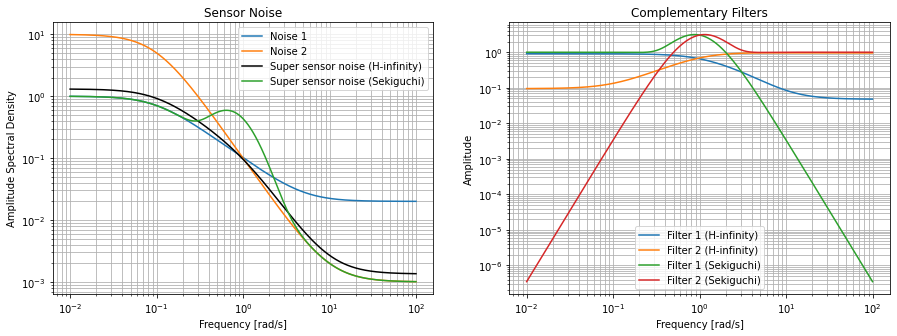

In [1]:
import kontrol
import control
import numpy as np
import matplotlib.pyplot as plt
import kontrol.frequency_series.noise_models
import kontrol.complementary_filter.predefined


omega = np.logspace(-2,2,1000)
f = omega/2/np.pi

s = control.tf("s")
tf_noise1 = (s/5 + 1) / (s/0.1 + 1)
tf_noise2 = 10 * (s/10 + 1)**2 / (s/0.1 + 1)**2


# comp_h2 = kontrol.ComplementaryFilter(noise1=tf_noise1, noise2=tf_noise2, f=omega, unit="omega")
comp_hinf = kontrol.ComplementaryFilter(noise1=tf_noise1, noise2=tf_noise2, f=omega, unit="omega")
# comp_h2.h2synthesis()
comp_hinf.hinfsynthesis()

## Let's compare with the Sekiguchi filter.

# The crossover is at around 1Hz
sekiguchi_filter1, sekiguchi_filter2 = kontrol.complementary_filter.predefined.sekiguchi([1])
sekiguchi_noise_super = kontrol.core.math.quad_sum(
    abs(sekiguchi_filter1(1j*omega))*abs(tf_noise1(1j*omega)),
    abs(sekiguchi_filter2(1j*omega))*abs(tf_noise2(1j*omega))
)


plt.figure(figsize=(15,5))
plt.subplot(121, title="Sensor Noise")
plt.loglog(omega, abs(tf_noise1(1j*omega)), label="Noise 1")
plt.loglog(omega, abs(tf_noise2(1j*omega)), label="Noise 2")
# plt.loglog(omega, comp_h2.noise_super)
plt.loglog(omega, comp_hinf.noise_super, color="k", label="Super sensor noise (H-infinity)")
plt.loglog(omega, sekiguchi_noise_super, label="Super sensor noise (Sekiguchi)")
plt.ylabel("Amplitude Spectral Density")
plt.xlabel("Frequency [rad/s]")
plt.legend(loc=0)
plt.grid(which="both")
plt.subplot(122, title="Complementary Filters")
# plt.loglog(omega, abs(comp_h2.filter1(1j*omega)))
# plt.loglog(omega, abs(comp_h2.filter2(1j*omega)))
plt.loglog(omega, abs(comp_hinf.filter1(1j*omega)), label="Filter 1 (H-infinity)")
plt.loglog(omega, abs(comp_hinf.filter2(1j*omega)), label="Filter 2 (H-infinity)")
plt.loglog(omega, abs(sekiguchi_filter1(1j*omega)), label="Filter 1 (Sekiguchi)")
plt.loglog(omega, abs(sekiguchi_filter2(1j*omega)), label="Filter 2 (Sekiguchi)")
plt.ylabel("Amplitude")
plt.xlabel("Frequency [rad/s]")
plt.legend(loc=0)
plt.grid(which="both")


The instance now is a TransferFunction object with 2 inputs and 1 outputs and it follows python-control's notation.

In [2]:
comp_hinf

TransferFunction([[array([6.24996094e-06, 9.44373975e+06, 2.36561272e+08, 1.89810352e+09,
       4.76864769e+09])], [array([9.99993750e-01, 1.89769549e+08, 1.96312387e+09, 5.17091065e+09,
       4.97649620e+08])]], [[array([1.00000000e+00, 1.99213289e+08, 2.19968514e+09, 7.06901417e+09,
       5.26629731e+09])], [array([1.00000000e+00, 1.99213289e+08, 2.19968514e+09, 7.06901417e+09,
       5.26629731e+09])]])

This extra step shouldn't be needed and we should be able to just call comp_hinf.foton to convert it to foton expression. But MIMO support isn't ready yet so we just demonstrate here.

In [3]:
filter1 = kontrol.TransferFunction(comp_hinf[0, 0])
filter1.foton

'zpk([240484360943.12234;1.5915494353647255+0.00018166314892340582j;1.5915494353647255-0.00018166314892340582j;0.8036581462113865],[31705777.934000853;0.8136400585838958;0.7746368863609777;0.1690896367698424],0.9055029386912142,"n")'